In [1]:
!pip install rdflib

In [2]:
!pip install pandas

In [3]:
import pandas as pd

In [63]:
import rdflib
import re
import datetime
from time import strptime
from datetime import date
import io
import seaborn as sns

In [5]:
players = pd.read_csv('C:/Users/Jay/Downloads/ipl/Players.csv')
players.head()


,Player_Name,DOB,Batting_Hand,Bowling_Skill,Country
0,A Ashish Reddy,24-Feb-91,Right_Hand,Right-arm medium,India
1,A Chandila,5-Dec-83,Right_Hand,Right-arm offbreak,India
2,A Chopra,19-Sep-77,Right_Hand,Right-arm offbreak,India
3,A Choudhary,NaN,Right_hand,Left-arm fast-medium,NaN
4,A Dananjaya,NaN,Right_Hand,Right-arm offbreak,NaN


In [6]:
most_runs_avg = pd.read_csv('C:/Users/Jay/Downloads/ipl/most_runs_average_strikerate.csv')
most_runs_avg.head()

,batsman,total_runs,out,numberofballs,average,strikerate
0,V Kohli,5426,152,4111,35.697368,131.987351
1,SK Raina,5386,160,3916,33.662500,137.538304
2,RG Sharma,4902,161,3742,30.447205,130.999466
3,DA Warner,4717,114,3292,41.377193,143.286756
4,S Dhawan,4601,137,3665,33.583942,125.538881


In [7]:
from rdflib.namespace import DC, DCTERMS, DOAP, FOAF, SKOS, OWL, RDF, RDFS, VOID, XMLNS, XSD

In [8]:
from rdflib import URIRef, Namespace, Literal, BNode

In [9]:
today = date.today()
# dd/mm/YY
today = str(today.strftime("%d/%m/%y"))
today_year = today.split("/")[2]


In [10]:
SCHEMA = Namespace("http://schema.org/")
IPL = Namespace("http://data.ipl.com/ont#")


In [11]:
g = rdflib.Graph()

In [12]:
for index,row in players.iterrows():
    player_name = URIRef(IPL + re.sub('\\W+','', row['Player_Name'] ))
    DOB = str(row['DOB'])
    bowling_skill = str(row['Bowling_Skill'])
    batting_hand = str(row['Batting_Hand'])
    country = str(row['Country'])
    
    '''
    if(len(DOB)>0 and DOB != 'nan'):
        month = DOB.split("-")[1]
        day = DOB.split("-")[0]
        year = DOB.split("-")[2]
    formated_month = str(strptime(month,'%b').tm_mon)
    print(int(day),int(formated_month),int(year))
    formated_date = datetime.datetime(int(year), int(formated_month), int(day))
    formated_date.strftime('%d-%m-%y')
    print(formated_date)
    '''
    
    if(len(DOB)>0 and DOB != 'nan'):
        month = DOB.split("-")[1]
        day = DOB.split("-")[0]
        year = DOB.split("-")[2]
        if(int(year)>=int(today_year)):
            year = str(int(today_year)-1) + year
        else:
            year = today_year + year
        
    
    formated_month = str(strptime(month,'%b').tm_mon)
    formated_date = datetime.datetime(int(year), int(formated_month), int(day))
    formated_date.strftime('%d-%m-%Y')

    birth_Date = Literal(str(formated_date), datatype = XSD.date)
    
    
    g.add((player_name, RDF.type, IPL.Player))
    g.add((player_name, SCHEMA.birthDate, birth_Date))
    
    if(len(country)>0):
        country = Literal(row['Country'])
        g.add((player_name, SCHEMA.Country, country))
    
    
    if(len(batting_hand)>0):
        batsman_bnode = BNode()
        g.add((player_name, IPL.PlayerRole, batsman_bnode))
        g.add((batsman_bnode, RDF.type, IPL.Batsman))
        if('Right' in batting_hand):
            g.add((batsman_bnode, IPL.stands, IPL.RightHanded))
        if('Left' in batting_hand):
            g.add((batsman_bnode, IPL.stands, IPL.LeftHanded))
    
    
    if(len(bowling_skill)>0 and bowling_skill != 'Null' and bowling_skill != 'null'):
        bowler_bnode = BNode()
        g.add((player_name, IPL.PlayerRole, bowler_bnode))
        g.add((bowler_bnode, RDF.type, IPL.Bowler))
        if('Right' in bowling_skill):
            g.add((bowler_bnode, IPL.bowls, IPL.RightHanded))
        if('Left' in bowling_skill):
            g.add((bowler_bnode, IPL.bowls, IPL.LeftHanded))
        if('fast' in bowling_skill):
            g.add((bowler_bnode, IPL.pace, IPL.FastPace))
        if('Medium' in bowling_skill):
            g.add((bowler_bnode, IPL.pace, IPL.MediumPace))
        if('slow' in bowling_skill or 'break' in bowling_skill):
            g.add((bowler_bnode, IPL.pace, IPL.Spinner))
            g.add((bowler_bnode, IPL.SpinnerType, Literal(bowling_skill)))
            
        
    

In [13]:
for index,row in most_runs_avg.iterrows():
    player_name = URIRef(IPL + re.sub('\\W+','', row['batsman'] ))
    batsman_name = BNode()
    if(len(str(row['total_runs']))>0):
        g.add((batsman_name, IPL.Runs, Literal(row['total_runs'])))
    if(len(str(row['out']))>0):
        g.add((batsman_name, IPL.Wickets, Literal(row['out'])))
    if(len(str(row['numberofballs']))>0):
        g.add((batsman_name, IPL.BallsPhase, Literal(row['numberofballs'])))
    if(len(str(row['average']))>0):
        g.add((batsman_name, IPL.ScoreAverage, Literal(row['average'])))
    if(len(str(row['strikerate']))>0):
        g.add((batsman_name, IPL.Strikerate, Literal(row['strikerate'])))
    g.add((player_name, IPL.Bats, batsman_name))
    g.add((batsman_name, RDF.type, IPL.BattingStatistics))
   

In [14]:
g.serialize(destination="C:/Users/Jay/Downloads/IPL_Players.ttl",format="turtle")

In [16]:
!pip install pystardog

In [65]:
import stardog

conn_details = {
  'endpoint': 'http://localhost:5820',
  'username': 'admin',
  'password': 'admin'
}

with stardog.Admin(**conn_details) as admin:
    Test = admin.new_database('Test')

with stardog.Connection('Test', **conn_details) as conn:
    conn.begin()
    conn.add(stardog.content.File("C:/Users/Jay/Downloads/IPL_Players.ttl"))
    #conn.add(stardog.content.File("C:/Users/Jay/Downloads/IPL_Players.ttl"), graph_uri='<http:example.com>')
    conn.commit()
    results = conn.select('select * { ?a ?p ?o }')


StardogException: [400] 0D0DE2: Database already exists: Test

In [22]:
print(results)

{'head': {'vars': ['a', 'p', 'o']}, 'results': {'bindings': [{'p': {'type': 'uri', 'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'}, 'a': {'type': 'uri', 'value': 'http://data.ipl.com/ont#AABilakhia'}, 'o': {'type': 'uri', 'value': 'http://data.ipl.com/ont#Player'}}, {'p': {'type': 'uri', 'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'}, 'a': {'type': 'uri', 'value': 'http://data.ipl.com/ont#AAChavan'}, 'o': {'type': 'uri', 'value': 'http://data.ipl.com/ont#Player'}}, {'p': {'type': 'uri', 'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'}, 'a': {'type': 'uri', 'value': 'http://data.ipl.com/ont#AAJhunjhunwala'}, 'o': {'type': 'uri', 'value': 'http://data.ipl.com/ont#Player'}}, {'p': {'type': 'uri', 'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'}, 'a': {'type': 'uri', 'value': 'http://data.ipl.com/ont#AAKazi'}, 'o': {'type': 'uri', 'value': 'http://data.ipl.com/ont#Player'}}, {'p': {'type': 'uri', 'value': 'http://www.w3.org/1999/02/22-rdf-synt

In [24]:
conn.size()

9002

In [61]:
query1="""
PREFIX ipl:<http://data.ipl.com/ont#>
PREFIX schema:<http://schema.org>
SELECT ?Player ?Stanze (ROUND (((?TotalRun/?numberofballs)*100)) AS ?strikerate)
{
    ?Player a ipl:Player;
                ipl:PlayerRole ?role.
    ?role a ipl:Batsman;
                ipl:stands ?Stanze.
    ?Player a ipl:Player;
            ipl:Bats ?batsman.
    ?batsman a ipl:BattingStatistics;
             ipl:Runs ?TotalRun;
             ipl:BallsPhase ?numberofballs.
    FILTER(?numberofballs>1000) 
    
             
}
ORDER BY DESC(?strikerate)
LIMIT 10"""
results=conn.select(query1,content_type='text/csv')
df=pd.read_csv(io.BytesIO(results))
df.head()

,Player,Stanze,strikerate
0,http://data.ipl.com/ont#RRPant,http://data.ipl.com/ont#LeftHanded,165.0
1,http://data.ipl.com/ont#VSehwag,http://data.ipl.com/ont#RightHanded,156.0
2,http://data.ipl.com/ont#CHGayle,http://data.ipl.com/ont#LeftHanded,152.0
3,http://data.ipl.com/ont#ABdeVilliers,http://data.ipl.com/ont#RightHanded,152.0
4,http://data.ipl.com/ont#KAPollard,http://data.ipl.com/ont#RightHanded,148.0


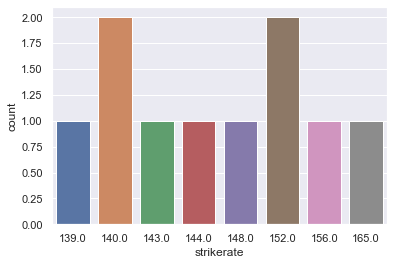

In [64]:
sns.set(style='darkgrid')
sns.countplot(x='strikerate', data = df)

In [93]:
query2 = """
PREFIX ipl:<http://data.ipl.com/ont#>
PREFIX schema:<http://schema.org>
SELECT ?Player ?Runs ?numberofballs
{{
    ?Player a ipl:Player;
            ipl:Bats ?Batsman.
    ?Batsman a ipl:BattingStatistics;
            ipl:Runs ?Runs;
            ipl:BallsPhase ?numberofballs.
            FILTER(?Player = ipl:{0})
}}
"""
results=conn.select(query2.format('AAChavan'),content_type='text/csv')
df=pd.read_csv(io.BytesIO(results))
df.head()

,Player,Runs,numberofballs
0,http://data.ipl.com/ont#AAChavan,12,11
